## Closing the water balance using remote sensing data

*ENVM1502* - March 2025

### Introduction

Consider the monthly water balance for a river basin:

$$S_t = S_{t-1} + P_t - E_t - Q_t$$

Here, $S_{t−1}$ and $S_t$ are total water storage (surface and subsurface) in the basin at the start and end of month $t$, $P_t$ and $E_t$ are basin average precipitation and evaporation (including transpiration), and $Q_t$ is river discharge at the basin outlet for month $t$. Each term is normalized by basin area and expressed in consistent water depth units (e.g. mm). For simplicitiy, lateral groundwater flow into or out of the basin is ignored, as are inter-basin water transfers.

We can obtain independent estimates for each of the water balance components, e.g. from satellite data (water storage, precipitation, evaporation) and from ground-based observations (river discharge). However, bringing these multi-source data together into the basin-scale water balance equation typically leads to significant water balance errors: in any particular month, we end up with either too much or too little water.  

The reason the water balance does not close is that each dataset contains errors, both systematic ("bias") and random ("noise"). In principle, the underlying unknown "true" (error-free) water balance variables should close the water balance. As such, to compensate for data errors, we could make adjustments to the original data values to bring them closer to their true values until we obtain a set of values that closes the water balance. In this setup, data with large errors can in principle be adjusted more than data with small errors.

The notebook consists of three parts:
1. *Errors in water balance data*: introduces the monthly water balance data for the case study river basin and defines probabilistic models to describe errors in the data.
2. *Uncertainty propagation and Gaussian product*: introduces the two basic building blocks for doing data assimilation by looking at a single month.
3. *Kalman filtering and smoothing*: incorporates the building blocks from part 2 into a data assimilation algorithm that loops over all months.

In [196]:
# useful imports
from scipy.stats import norm#the normal distribution
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Part 1: Errors in water balance data

C:\Users\margh\AppData\Local\Temp\ipykernel_28780\156728138.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dfera5_forcing = dfera5_forcing.resample('M').mean()


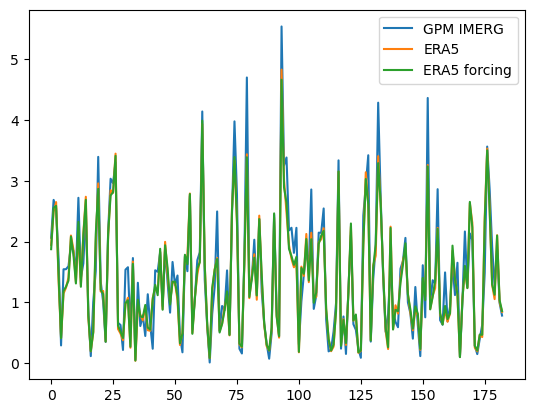

,pr,time_bnds,lat,lat_bnds,lon,lon_bnds
time,,,,,,
2002-03-31,0.000022,2002-03-16 12:00:00,39.625,39.625,-1.625,-1.625
2002-04-30,0.000030,2002-04-16 00:00:00,39.625,39.625,-1.625,-1.625
2002-05-31,0.000030,2002-05-16 12:00:00,39.625,39.625,-1.625,-1.625
2002-06-30,0.000017,2002-06-16 00:00:00,39.625,39.625,-1.625,-1.625
2002-07-31,0.000005,2002-07-16 12:00:00,39.625,39.625,-1.625,-1.625
...,...,...,...,...,...,...
2017-01-31,0.000015,2017-01-16 12:00:00,39.625,39.625,-1.625,-1.625
2017-02-28,0.000013,2017-02-15 00:00:00,39.625,39.625,-1.625,-1.625
2017-03-31,0.000024,2017-03-16 12:00:00,39.625,39.625,-1.625,-1.625


In [197]:
# Read and plot the monthly precipitation data
# Read the CSV files with the correct encoding
nasap  = pd.read_csv('Jucar_NASA_precipitation.csv', sep = ',', dtype=float, encoding='latin1')
era5p  = pd.read_csv('Jucar_ERA5_total_precipitation_sum.csv', sep = ',', dtype=float, encoding='latin1')

dfnasap = pd.DataFrame(nasap)
# Convert 'system:index' to datetime format and extract year and month
dfnasap.index = pd.to_datetime(dfnasap['system:index'], format='%Y%m%d%H%M%S').dt.to_period('M').astype(str)
dfnasap = dfnasap[(dfnasap.index >= '2002-03') & (dfnasap.index <= '2017-05')]
dfnasap = dfnasap.drop(columns=['system:index'])
dfnasap['precipitation'] = dfnasap['precipitation']*24
nasap = np.array(dfnasap['precipitation'])

df_era5p = pd.DataFrame(era5p)
df_era5p.index = pd.to_datetime(df_era5p['system:index'], format='%Y%m').dt.to_period('M').astype(str)
df_era5p = df_era5p[(df_era5p.index >= '2002-03') & (df_era5p.index <= '2017-05')]
df_era5p = df_era5p.drop(columns=['system:index'])
df_era5p['precipitation'] = df_era5p['total_precipitation_sum']*1000/30
era5p = np.array(df_era5p['precipitation'])

import xarray as xr
era5_forcing = xr.open_dataset('OBS6_ERA5_reanaly_1_day_pr_2000-2018_newbasin.nc')
dfera5_forcing = era5_forcing.to_dataframe()
# Reset the index to access the 'time' level
dfera5_forcing = dfera5_forcing.reset_index(level=0)
# Convert the 'time' column to datetime and then to a monthly period
dfera5_forcing['time'] = pd.to_datetime(dfera5_forcing['time']).dt.to_period('M').astype(str)
# Set the 'time' column back as the index
dfera5_forcing.set_index('time', inplace=True)
# Ensure the index is a DatetimeIndex before resampling
dfera5_forcing.index = pd.to_datetime(dfera5_forcing.index)
dfera5_forcing = dfera5_forcing.resample('M').mean()
dfera5_forcing  = dfera5_forcing[(dfera5_forcing.index >= '2002-03') & (dfera5_forcing.index <= '2017-06')]  
era5_forcing = dfera5_forcing['pr']*86400
era5_forcing = np.array(era5_forcing)

plt.plot(range(len(nasap)),nasap, label="GPM IMERG")
plt.plot(range(len(era5p)),era5p, label="ERA5")
plt.plot(range(len(era5_forcing)),era5_forcing, label="ERA5 forcing")
#plt.plot(range(len(era5p_forcing )),era5p_forcing , label="ERA5 forcing")
plt.legend()
plt.show()

dfera5_forcing

In any given month, there are clearly differences in precipitation between the datasets, especially for wet months. A common approach is to use the variation between datasets to characterize data errors: large spread between datasets suggests large error and uncertainty. The simplest implementation of this idea is to use the mean and variance across the datasets to characterize precipitation uncertainty. Note however that this is by no means the only or best approach - it is an open research question how to characterize errors in precipitation (and other) datasets. 

In each month, the sample mean $m$ and variance $v$ across $N$ datasets can be computed as:

$$m = \frac{1}{N}\sum_{i=1}^N x_i$$
$$v = \frac{1}{N-1}\sum_{i=1}^N (x_i - m)^2$$

If we apply these equations to the three precipitation datasets, we get monthly values of $m_P$ and $v_P$, which we interpret as mean and variance of a normal (Gaussian) distribution $\mathcal{N}(P|m_P, v_P)$ for the precipitation errors (uncertainty) in each month.

In [198]:
# Compute monthly mean mP and variance vP of precipitation
mP = 1/2*(nasap+era5p)
vP = ((nasap-mP)**2+(era5p-mP)**2)
#print(f'monthly mean = {mP}, variance = {vP}')


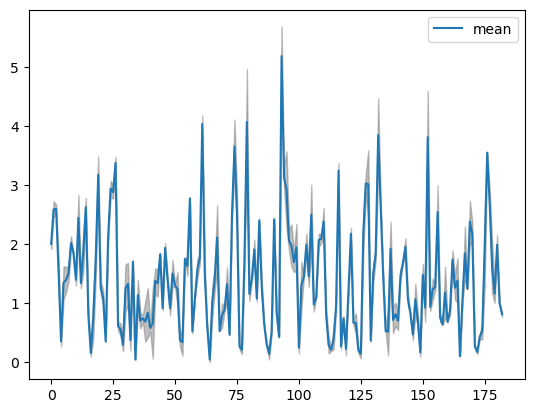

In [199]:
# Plot monthly mean and uncertainty interval (+-sigma) of precipitation.
plt.plot(range(len(mP)), mP, label = 'mean')
plt.fill_between(range(len(mP)), mP-np.sqrt(vP), mP+np.sqrt(vP), color='grey', alpha=0.5)
plt.legend()
plt.show()
# The plt.fill_between() function is useful for plotting an uncertainty interval.


#### Evaporation data

C:\Users\margh\AppData\Local\Temp\ipykernel_28780\768374571.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dfmodis = (dfmodis['ET'] / 80).resample('M').mean()


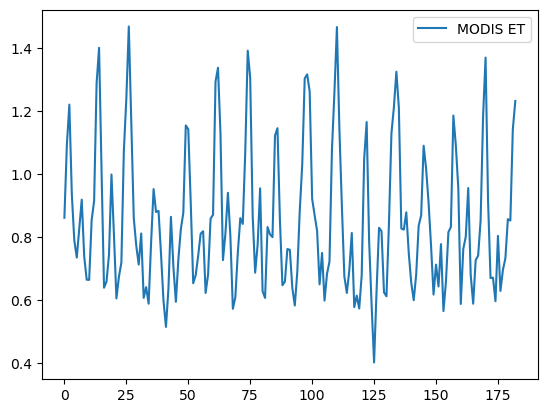

system:index
2002-03-31    0.861767
2002-04-30    1.094322
2002-05-31    1.221395
2002-06-30    0.936444
2002-07-31    0.790108
                ...   
2017-01-31    0.733102
2017-02-28    0.857543
2017-03-31    0.853090
2017-04-30    1.143073
2017-05-31    1.233003
Freq: ME, Name: ET, Length: 183, dtype: float64

In [200]:
# Read and plot the monthly evaporation data
modis  = pd.read_csv('Jucar_MOD16A2_ET.csv', sep = ',', encoding='latin1')

#import xarray as xr

# Read the NetCDF file using xarray
#era5e = xr.open_dataset('Derived_Makkink_evspsblpot_newbasin.nc')
#dfera5e = era5e.to_dataframe()
#dfera5e = dfera5e.resample('M').mean()
#fera5e = dfera5e.drop(columns=['latitude','longitude'])
#dfera5e = dfera5e[dfera5e.index >= '2001-01-01']  
#era5e = dfera5e['evspsblpot']*86400
#era5e = np.array(era5e)

#print(dfera5e)


dfmodis = pd.DataFrame(modis)
# Convert 'system:index' to datetime format and extract year and month
dfmodis['system:index'] = pd.to_datetime(dfmodis['system:index'], format='%Y_%m_%d')
dfmodis.set_index('system:index', inplace=True)
dfmodis = (dfmodis['ET'] / 80).resample('M').mean()
dfmodis = dfmodis[(dfmodis.index >= '2002-03') & (dfmodis.index <= '2017-06')]
modis = np.array(dfmodis)

#print(dfmodis)

plt.plot(range(len(modis)),modis, label="MODIS ET")
plt.legend()
plt.show()

dfmodis

In [201]:
mE = modis
vE = ((0.1*mE)**2)

#### River discharge data

The provided file `runoff.txt` contains monthly river discharge (mm) from a stream gauge at the river basin outlet. 

C:\Users\margh\AppData\Local\Temp\ipykernel_28780\3657999155.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Q = pd.read_csv(filename, delim_whitespace=True, index_col=0, usecols=[0, 4])
C:\Users\margh\AppData\Local\Temp\ipykernel_28780\3657999155.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Q = Q.resample('M').mean()
C:\Users\margh\AppData\Local\Temp\ipykernel_28780\3657999155.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


[0.05616331 0.05910972 0.11492868 0.07722862 0.15849646 0.13297998
 0.0560818  0.05264616 0.05315631 0.04720516 0.06170023 0.05472671
 0.04609699 0.11846438 0.17446568 0.15799545 0.19335927 0.19543505
 0.08195836 0.07257427 0.06357593 0.05397026 0.0569885  0.04997049
 0.06243284 0.15200543 0.17067964 0.14142608 0.1207332  0.15614796
 0.08209672 0.08224568 0.08128053 0.06880679 0.05503333 0.05685897
 0.06003121 0.11857087 0.20714647 0.19257823 0.12344458 0.09411114
 0.05110713 0.04562966 0.04549768 0.04588104 0.0411875  0.05148671
 0.05703065 0.05199114 0.06352489 0.06655977 0.08596486 0.09571624
 0.05453718 0.03043462 0.04352063 0.03762488 0.04463363 0.04884604
 0.04689994 0.05282928 0.09434677 0.09184744 0.08467441 0.09891243
 0.05273311 0.06298481 0.04207114 0.05700625 0.05140659 0.04934351
 0.05346539 0.04890001 0.0616805  0.05938029 0.04583895 0.04688783
 0.04846553 0.10663884 0.07948869 0.07251528 0.06970496 0.0700196
 0.07623488 0.05603646 0.06549429 0.0560937  0.08206431 0.10374

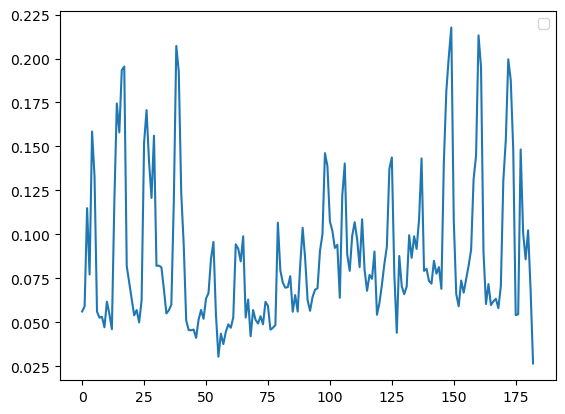

In [202]:
# Read and plot the monthly river discharge data
filename = "Upstream_Q.txt"
Q = pd.read_csv(filename, delim_whitespace=True, index_col=0, usecols=[0, 4])
# Ensure the index is converted to a DatetimeIndex
Q = pd.DataFrame(Q)
Q.index = pd.to_datetime(Q.index, errors='coerce')
Q = Q[(Q.index >= '2002-03') & (Q.index <= '2017-05')]  
Q = Q.resample('M').mean()
Q = np.array(Q).flatten()
print(Q)


plt.plot(range(len(Q)),Q)
plt.legend()
plt.show()


Uncertainty and errors in river discharge measurements can in principle be estimated using a rating curve error analysis. Here, we will assume a 10% relative error in each month, reflecting the common situation of greater errors for measuring larger flow rates. This assumption allows us to compute a Gaussian distribution $\mathcal{N}(Q|m_Q, v_Q)$ for river discharge uncertainty in each month, where $m_Q$ is equal to the discharge measurement (unbiased measurement) and $v_Q$ is computed from the 10% error assumption.

In [203]:
# Compute monthly mean mQ and variance vQ of river discharge
mQ = Q
vQ = ((0.1*mQ)**2)
vQ


array([3.15431763e-05, 3.49395855e-05, 1.32086023e-04, 5.96425916e-05,
       2.51211270e-04, 1.76836763e-04, 3.14516878e-05, 2.77161767e-05,
       2.82559366e-05, 2.22832720e-05, 3.80691815e-05, 2.99501317e-05,
       2.12493206e-05, 1.40338085e-04, 3.04382726e-04, 2.49625617e-04,
       3.73878071e-04, 3.81948591e-04, 6.71717268e-05, 5.26702428e-05,
       4.04189866e-05, 2.91278875e-05, 3.24768923e-05, 2.49704950e-05,
       3.89785889e-05, 2.31056504e-04, 2.91315406e-04, 2.00013368e-04,
       1.45765044e-04, 2.43821851e-04, 6.73987171e-05, 6.76435206e-05,
       6.60652507e-05, 4.73437389e-05, 3.02866744e-05, 3.23294266e-05,
       3.60374562e-05, 1.40590512e-04, 4.29096596e-04, 3.70863747e-04,
       1.52385644e-04, 8.85690743e-05, 2.61193870e-05, 2.08206595e-05,
       2.07003868e-05, 2.10506982e-05, 1.69640990e-05, 2.65088161e-05,
       3.25249548e-05, 2.70307886e-05, 4.03541206e-05, 4.43020251e-05,
       7.38995754e-05, 9.16159937e-05, 2.97430355e-05, 9.26265832e-06,
      

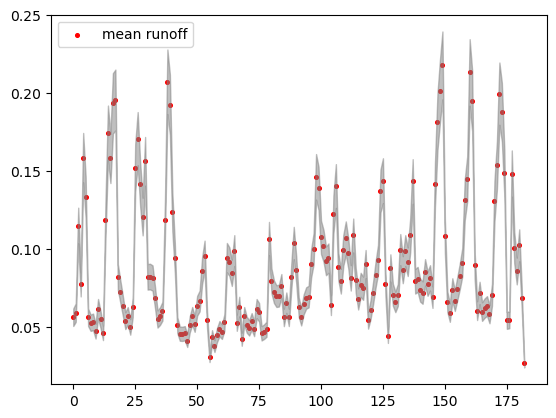

In [204]:
# Plot monthly mean and uncertainty interval (+-sigma) of river discharge
plt.scatter(range(len(mQ)), mQ, label = 'mean runoff', color='red', s=7)
plt.fill_between(range(len(mQ)), mQ-np.sqrt(vQ), mQ+np.sqrt(vQ), color='grey', alpha=0.5)
plt.legend()
plt.show()

#### Water storage data

Monthly time-series of total water storage (anomalies relative to period 2004-2010) is provided in file `graceJPL.txt` (total water storage from the [JPL-Mascon GRACE](https://developers.google.com/earth-engine/datasets/catalog/NASA_GRACE_MASS_GRIDS_MASCON_CRI) dataset). This dataset also comes with an estimate of the standard error (square root of error variance) in the monthly data, provided in file `graceJPLerror.txt` (standard error of the GRACE data). Note that the GRACE data include months with missing data; these are indicated with a nodata value of -99999. 

C:\Users\margh\AppData\Local\Temp\ipykernel_28780\1558624329.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['lwe_thickness'].fillna(-99999, inplace=True)
C:\Users\margh\AppData\Local\Temp\ipykernel_28780\1558624329.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



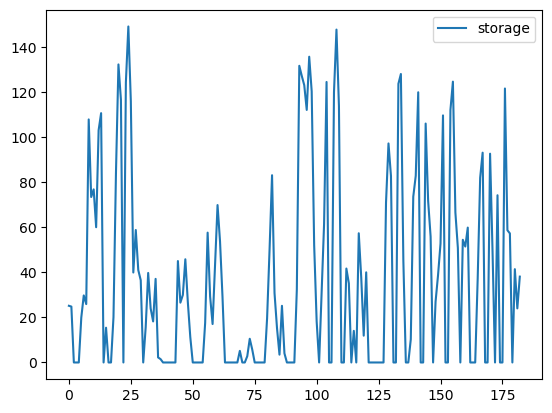

In [205]:
# Read and plot the monthly storage data
# Read the CSV file

storage_df = pd.read_csv('Jucar_NASA_GRACE_Iwe_thickness.csv', sep=',', encoding='latin1')
stderror_df = pd.read_csv('Jucar_NASA_GRACE_uncertainty.csv', sep=',', encoding='latin1')

# === Parse dates (first 8 digits of 'system:index') ===
storage_df['date'] = pd.to_datetime(storage_df['system:index'].str[:8], format='%Y%m%d')
storage_df['month'] = storage_df['date'].dt.to_period('M')

stderror_df['date'] = pd.to_datetime(stderror_df['system:index'].str[:8], format='%Y%m%d')
stderror_df['month'] = stderror_df['date'].dt.to_period('M')

# === Monthly averaging (if duplicates) ===
storage_df = storage_df.groupby('month').mean(numeric_only=True).reset_index()
stderror_df = stderror_df.groupby('month').mean(numeric_only=True).reset_index()

# === Create full month range and merge ===
full_month_range = pd.period_range(start=storage_df['month'].min(), end=storage_df['month'].max(), freq='M')
full_df = pd.DataFrame({'month': full_month_range})

# Merge and fill missing with -99999
full_df = full_df.merge(storage_df[['month', 'lwe_thickness']], on='month', how='left')
full_df = full_df.merge(stderror_df[['month', 'uncertainty']], on='month', how='left')
full_df['lwe_thickness'].fillna(-99999, inplace=True)
full_df['uncertainty'].fillna(-99999, inplace=True)

# Convert to arrays
storage = (full_df['lwe_thickness'].to_numpy())*10
stderror = (full_df['uncertainty'].to_numpy())*10

# Optional: Replace negative values (excluding -99999) with 0 for storage
storage = np.where((storage < 0) & (storage != -99999), 0, storage)

for i in range(0,len(storage)):
    if (storage[i] == -99999):
        storage[i] = np.nan


plt.plot(range(len(storage)),storage, label="storage")
plt.legend()
plt.show()


Since the GRACE dataset come with its own estimate of data error we will use it directly to get a Gaussian distribution $\mathcal{N}(S|m_S, v_S)$ for the uncertainty in water storage in each month. Here, $m_S$ is taken as the GRACE measurement and $v_S$ is set to the square of the GRACE standard error.

*Hint: to handle missing data values in the GRACE time-series you can for example set $m_S = 0$ and $v_S = 10^9$ (some large variance). Using a large variance represents a data value with extreme uncertainty, which is essentially equivalent to having no data for that month.*

In [206]:
# Compute monthly mean mS and variance vS of water storage
mS = np.zeros(len(storage))
vS = np.zeros(len(storage))
for i in range(0,len(storage)):
    if (np.isnan(storage[i])):
        mS[i] = 0
        vS[i] = 10**9
    else:
        mS[i] = storage[i]
        vS[i] = stderror[i]**2 
print(vS)

[3.57227487e+03 1.52186944e+03 9.99980000e+11 9.99980000e+11
 9.78018218e+02 1.53387814e+03 5.94118276e+02 5.40271447e+02
 6.58259462e+02 9.05549906e+02 6.20525726e+02 4.54159548e+02
 4.16225350e+02 4.38749727e+02 9.99980000e+11 1.96890090e+02
 2.02173106e+02 1.94991674e+02 1.91450223e+02 1.88555720e+02
 1.84031159e+02 2.90771024e+02 9.99980000e+11 1.84809469e+02
 1.81328239e+02 1.97760254e+02 2.03968357e+02 1.74606242e+02
 1.97246164e+02 2.23797433e+02 1.81463901e+02 2.14150433e+02
 2.05127522e+02 1.85404101e+02 2.11522276e+02 2.15450070e+02
 2.14457099e+02 2.27621715e+02 2.39010256e+02 2.18531999e+02
 2.10413989e+02 2.09571848e+02 2.02496731e+02 2.00043208e+02
 3.40217954e+02 2.29374513e+02 2.25157684e+02 2.00622437e+02
 2.02949898e+02 2.02756571e+02 2.41079702e+02 2.15381264e+02
 1.89970911e+02 2.19022881e+02 2.05340380e+02 2.02730073e+02
 2.23809628e+02 2.33579996e+02 2.15276951e+02 2.06624375e+02
 2.12102732e+02 2.01881520e+02 2.19115919e+02 2.01738453e+02
 2.52391637e+02 2.230210

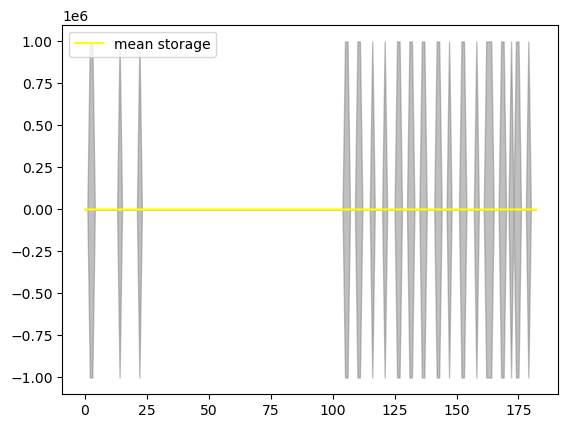

In [207]:
# Plot monthly mean and uncertainty interval (+-sigma) of water storage
plt.plot(range(len(mS)), mS, label = 'mean storage', color='yellow')
plt.fill_between(range(len(mS)), mS-np.sqrt(vS), mS+np.sqrt(vS), color='grey', alpha=0.5)
plt.legend()
plt.show()

# Part 2: Uncertainty propagation and Gaussian product 

Data assimilation relies on two basic building blocks:
* Uncertainty propagation: how to propagate uncertainty through a deterministic function, in our case the water balance (linear equation)?
* Gaussian product: how to combine two (or more) Gaussian distributions over the same variable?

This part explores these two building blocks and applies them to a water balance for a single month with noisy information on each water balance component in the form of Gaussian distributions:

$$\mathcal{N}(S_0|m_{S_0}, v_{S_0}), \mathcal{N}(P|m_{P}, v_{P}), \mathcal{N}(E|m_{E}, v_{E}), \mathcal{N}(Q|m_{Q}, v_{Q})$$
$$S = S_0 + P - E - Q$$
$$\mathcal{N}(S|m_{S}, v_{S})$$

Specifically, we aim to compute posterior distributions for individual water balance variables that combine information from the water balance and from the noisy measurement of that variable.

#### Uncertainty propagation

How to propagate uncertainty through a linear equation like the water balance? This can be done using basic formulas for the mean and variance of a linear combination of random variables. Remember that if $y = \sum_i a_i x_i$, then the mean of $y$ is $\sum_i a_i m_i$ and the variance of $y$ is $\sum_i a_i^2 v_i$, where $m_i$ and $v_i$ are mean and variance of each $x_i$, and each $a_i$ is a known constant. In the case of the water balance, each $a_i$ will be either $1$ or $-1$. These formulas apply if all $x_i$ are uncorrelated.

**Example 1**: given $m_P = 40.5$, $v_P = 10.2$, $m_E = 20.3$, $v_E = 10.9$, $m_Q = 5.3$, $v_Q = 0.5$, $m_{S_0} = 100$, $v_{S_0} = 100$, $m_S = 100$, $v_S = 100$. Apply uncertainty propagation and verify that the resulting distribution from water balance to $S$ has mean and variance equal to 114.9 and 121.6. Also verify that the resulting distribution from water balance to $P$ has mean and variance equal to 25.6 and 211.4. To apply uncertainty propagation to $P$, first rewrite the water balance so that $P$ is expressed as output on the left with the other variables on the right as input variables.

In [208]:
mP1 = 40.5
vP1 = 10.2
mE1 = 20.3
vE1 = 10.9
mQ1 = 5.3
vQ1 = 0.5
mS01 = 100
vS01 = 100
mS1 = 100
vS1 = 100

mS_U = 1*mP1+1*mS01-1*mE1-1*mQ1
print(mS_U)
vS_U = vP1+vS01+vE1+vQ1
print(vS_U)

mP_U = mS1-mS01+mE1+mQ1
print(mP_U)
vP_U = vS1+vS01+vE1+vQ1
print(vP_U)

114.9
121.60000000000001
25.6
211.4


#### Gaussian product

How to combine two (or more) Gaussian distributions over the same variable? If we have two *independent* noisy sources of information for the same variable, in the form of two (Gaussian) distributions for that variable, then we can simply multiply these two (Gaussian) distributions. This is a basic rule of probability and also applies if the distributions are not Gaussian.

In the special case of two Gaussian densities, $\mathcal{N}(x|m_1,v_1)$ and $\mathcal{N}(x|m_2,v_2)$, for the same variable $x$, their product is proportional to a new Gaussian density for $x$:

$$ \mathcal{N}(x|m_1,v_1)\mathcal{N}(x|m_2,v_2) = \mathcal{N}(m_1|m_2,v_1+v_2)\mathcal{N}(x|m,v) $$

The first term on the right, $\mathcal{N}(m_1|m_2,v_1+v_2)$, is the proportionality constant (it's a number independent of $x$). The second term on the right, $\mathcal{N}(x|m,v)$, is the new Gaussian distribution for $x$ that combines information from the two Gaussians on the left. Its mean $m$ and variance $v$ are given by:

$$m = w_1 m_1 + w_2 m_2$$
$$v = w_1 v_1 = w_2 v_2$$

where weights $w_1 = \frac{v_2}{v_1 + v_2}$ and $w_2 = 1 - w_1 = \frac{v_1}{v_1 + v_2}$ have values between 0 and 1. These formulas can be derived by writing out the formulas for the two original Gaussian densities and [completing the square](https://en.wikipedia.org/wiki/Completing_the_square).

We see that the new Gaussian density for $x$ has a mean $m$ that lies in between the two original means $m_1$ and $m_2$, with interpolating weights $w_1$ and $w_2$ computed from the two original variances $v_1$ and $v_2$. If the two original Gaussians have the same noise level ($v_1 = v_2$), then $w_1 = w_2 = 0.5$ and the new mean is simply the average of the two original means. If on the other hand one Gaussian has more noise than the other, say $v_1 > v_2$, then according to the weight formulas we have $w_2 > w_1$, and thus the new mean will be closer to $m_2$ than to $m_1$, i.e. it is closer to the less noisy Gaussian. Intuitively this makes sense: when combining sources of information with different noise levels, the noisier (more uncertain) ones carry less weight in the final result. 

The formula for the new variance shows that, since weights $w_1$ and $w_2$ are less than 1, $v$ will be less than the two original variances, i.e. $v <= v_1$ and $v <= v_2$. The interpretation is that combining multiple (Gaussian!) sources of information reduces the uncertainty about variable $x$ compared to using a single source of information.

If there are more than two Gaussian sources of information (e.g. three noisy observations of the same variable), the formulas above can simply be repeated multiple times to process and incorporate each Gaussian in turn. The order in which this is done does not matter.

Complete the `gaussian_product` function below using the Gaussian product formula. The function takes in means and variances of two Gaussian distributions over the same variable, and returns mean and variance of the product of the two distributions. Test your function with the following inputs: $m_1=10.2$, $v_1=2$ , $m_2=5.6$, $v_2=1$; you should get $m=7.13$ and $v=0.67$.

In [209]:
def gaussian_product(m1, v1, m2, v2):
    w1 = v2/(v1+v2)
    w2 = 1-w1
    
    m = w1*m1 + w2*m2
    v = w1*v1
    return m, v

In [210]:
m,v = gaussian_product(10.2,2,5.6,1)
print(m,v)

7.133333333333333 0.6666666666666666


#### Posterior of S

To compute the posterior distribution of $S$, we combine information from the water balance (via uncertainty propagation of the noisy inputs through the water balance to output $S$) with the noisy measurement of $S$ (via Gaussian product).

**Example 2**: given same values as in Example 1, verify that the resulting posterior mean and variance of $S$ are equal to 106.72 and 54.87. If $v_S = 10^9$, verify that the resulting posterior mean and variance of $S$ are equal to 114.9 and 121.6. Explain the difference between these two cases.

In [211]:
print(gaussian_product(mS1,vS1,mS_U,vS_U))
print(gaussian_product(mS1,10**9,mS_U,vS_U))

(106.72382671480145, 54.87364620938629)
(114.89999818816023, 121.5999852134418)


#### Posterior of P

Similarly, to compute the posterior distribution of $P$, we combine information from the water balance with the noisy measurement of $P$.

**Example 3**: given the same numbers as in Example 1, verify that the resulting posterior mean and variance of $P$ are equal to 39.81 and 9.73 (for case $v_S = 100$) and 40.5 and 10.2 (for case $v_S = 10^9$). Again, explain the difference between these cases.

In [212]:
print(gaussian_product(mP1,vP1,mP_U,vP_U))

(39.814169675090255, 9.730505415162455)


# Part 3: Kalman filtering and smoothing

In this last part, we implement a Kalman filtering-smoothing algorithm to compute posteriors for all variables using data from all months. For this, we use the monthly time-series of data error distributions computed in part 1 and combine it with the uncertainty propagation and Gaussian product steps from part 2.

The algorithm uses a forward loop over all months, starting in the first month, to propagate noisy information from earlier to later months. This is followed by a backward loop over all months, starting in the last month, to propagate noisy information from later to earlier months. This ensures we obtain the best water balance estimates in each month that combine all available data over the entire period.

In each month we have a water balance constraint $S = S_0 + P - E - Q$ and noisy data distributions in the form of Gaussian distributions $\mathcal{N}(P|m_P, v_P)$, $\mathcal{N}(E|m_E, v_E)$, $\mathcal{N}(Q|m_Q, v_Q)$, and $\mathcal{N}(S|m_S, v_S)$, where all means and variances have been calculated using the data error models in part 1 of the notebook. For the first month only, we also specify a Gaussian distribution $\mathcal{N}(S_0|m_{S_0}, v_{S_0})$ for initial storage.

`Forward loop`
The loop starts at the first month. In each month, do the following:

1. *Predict*: compute forward distribution to 𝑆, $\mathcal{N}(S|m_{\rightarrow S}, v_{\rightarrow S})$, by propagating input distributions of $S_0$, $P$, $E$, and $Q$ through the water balance model. This forward distribution incorporates all data from earlier months.

2. *Update*: compute filtering posterior of 𝑆 by combining (multiplying) the forward distribution to 𝑆 (from step 1) with the noisy data distribution of 𝑆. This multiplication essentially adds data for current month, so that the filtering posterior incorporates all data up to and including the current month. 

The filtering posterior becomes input distribution for $S_0$ in next month. See the lecture for a visual aid of these steps in the form of a `factor graph`. 

`Backward loop`
The loop starts at the last month. In each month, do the following:

1. Compute smoothing posterior of 𝑆 by combining (multiplying) the filtering posterior and the backward distribution to 𝑆, $\mathcal{N}(S|m_{S \leftarrow}, v_{S \leftarrow})$. The latter incorporates all data from later months. As the filtering posterior incorporates all data up to and including the current month, the smoothing posterior combines all data.

2. Compute posteriors of $𝑃$, $𝐸$, and $𝑄$ by combining (multiplying) their prior/data and backward distributions. The backward distribution is computed by uncertainty propagation through the water balance (backward direction).

3. Compute backward distribution to $𝑆_0$ by uncertainty propagation through the water balance (backward direction). This becomes the backward distribution to 𝑆 for previous month (used in step 1 in next iteration of backward loop).

Complete the `close_water_balance` function below that implements the Kalman filtering-smoothing algorithm. You only need to implement things where it says "YOUR CODE HERE", using uncertainty propagation and Gaussian product from part 2 of the notebook. In principle, no extra arrays are needed beyond what is already in the code. The function takes as input monthly time-series of mean and variances computed in part 1 of the notebook (the Gaussian distributions for the data errors), and it returns monthly time-series of posterior means and variances for all water balance variables (including posterior mean and variance for initial storage of the first month).

In [213]:
def close_water_balance(mP, vP, mE, vE, mQ, vQ, mS, vS):
    # Specify prior mean and variance for initial storage S0 (first month)
    mS0 = 0
    vS0 = 200 * 200#large variance to indicate large uncertainty
    
    # Initialize posteriors
    # We compute these in forward loop (filtering posteriors) and then update them in backward loop (smoothing posteriors)
    nt = len(mP)#number of months in time-series
    mPostP = np.zeros(nt)#posterior mean of precipitation in each month
    vPostP = np.zeros(nt)#posterior variance of precipitation in each month
    mPostE = np.zeros(nt)#etc...
    vPostE = np.zeros(nt)
    mPostQ = np.zeros(nt)
    vPostQ = np.zeros(nt)
    mPostS = np.zeros(nt)
    vPostS = np.zeros(nt)
    
    
    # Forward loop (filtering)
    for t in range(nt):
        # Step 1: predict - compute forward distribution to S
        if(t==0):
            mToS = mP[t] + mS0 - mE[t] - mQ[t]
            vToS = vP[t] + vS0 + vE[t] + vQ[t]
        else:
            mToS = mP[t] + mPostS[t-1] - mE[t] - mQ[t]
            vToS = vP[t] + vPostS[t-1] + vE[t] + vQ[t]
        
        # Step 2: update - compute filtering posterior of S
        # YOUR CODE HERE
        mPostS[t], vPostS[t] = gaussian_product(mToS,vToS,mS[t],vS[t])
    #print(mPostS)
    #print(len(mPostS))

    
    # Backward loop (smoothing)
    mToS, vToS = 0.0, 1e+9 #represents backward distribution to S - initialize to wide Gaussian for last month
    for t in reversed(range(nt)):
        # Step 1: smoothing posterior of S
        # YOUR CODE HERE
        mPostS[t], vPostS[t] = gaussian_product(mToS,vToS,mPostS[t],vPostS[t])
        
        # Step 2: posteriors of P, E, and Q
        # YOUR CODE HERE
        mSto,vSto = gaussian_product(mToS,vToS,mS[t],vS[t])
        mPostP[t], vPostP[t] = gaussian_product(mP[t],vP[t],mSto - mPostS[t-1] + mE[t] + mQ[t],vSto + vPostS[t-1] + vE[t] + vQ[t])
        mPostE[t], vPostE[t] = gaussian_product(mE[t],vE[t],-mSto + mPostS[t-1] + mP[t] - mQ[t],vSto + vP[t] + vPostS[t-1] + vQ[t])
        mPostQ[t], vPostQ[t] = gaussian_product(mQ[t],vQ[t],-mSto + mPostS[t-1] - mE[t] + mP[t],vSto + vP[t] + vE[t] + vPostS[t-1])
        
        #mPostP[t], vPostP[t] = gaussian_product(mP[t],vP[t],mPostS[t]-mPostS[t-1]+mE[t]+mQ[t],vPostS[t] + vPostS[t-1] + vPostE[t] + vPostQ[t])
        #mPostE[t], vPostE[t] = gaussian_product(mE[t],vE[t],-mPostS[t]+mPostS[t-1]+mP[t]-mQ[t],vPostS[t] + vPostP[t] + vPostS[t-1] + vPostQ[t])
        #mPostQ[t], vPostQ[t] = gaussian_product(mQ[t],vQ[t],-mPostS[t]+mPostS[t-1]-mE[t]+mP[t],vPostS[t] + vPostP[t] + vPostE[t] + vPostS[t-1])
        
        # Step 3: backward distribution to S0
        # YOUR CODE HERE
        mToS = mSto - mP[t] + mE[t] + mQ[t]
        vToS = vSto + vP[t] + vE[t] + vQ[t]
      
    # After backward loop: compute posterior mean and variance of S0 (initial storage first month)
    # YOUR CODE HERE
    
    mPostS0, vPostS0 = gaussian_product(mToS,vToS,mPostS[0],vPostS[0])
    
    # Return final water balance estimates (posterior means and variances of monthly estimates)
    return mPostP, vPostP, mPostE, vPostE, mPostQ, vPostQ, mPostS, vPostS, mPostS0, vPostS0

Test and run your completed `close_water_balance` function. Verify that combining the monthly estimates of the different water balance variables (mPostP, mPostE, mPostQ, mPostS, mPostS0) gives a closing water balance in each month.

In [216]:
mPostP, vPostP, mPostE, vPostE, mPostQ, vPostQ, mPostS, vPostS, mPostS0, vPostS0 = close_water_balance(mP, vP, mE, vE, mQ, vQ, mS, vS)
 

Finally, also plot monthly time-series of the posteriors for each variable. For example, this can be done by plotting the posterior mean and uncertainty interval (+-sigma). Adding the original observations to the same plot is also useful.

In [217]:
def PlotPosterior(name, m, v, obs1, obs2, obs3):
    mu = m
    sigma = np.sqrt(v)
    lower = mu - sigma
    upper = mu + sigma
    plt.figure(figsize=(16,7))
    plt.fill_between(np.arange(len(lower)), lower, upper, color='grey', alpha=0.5)
    plt.plot(mu, 'k')
    plt.plot(np.ma.masked_values(obs1, -99999), 'r.')
    plt.plot(np.ma.masked_values(obs2, -99999), 'b.')
    plt.plot(np.ma.masked_values(obs3, -99999), 'g.')
    plt.ylabel(name)
    plt.show()

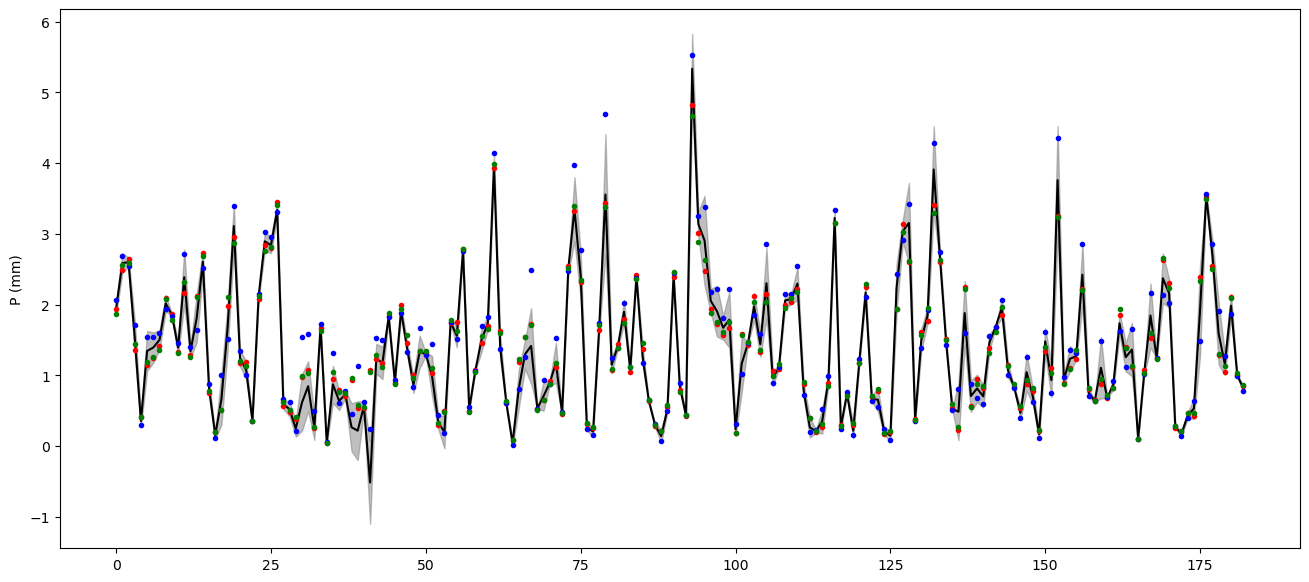

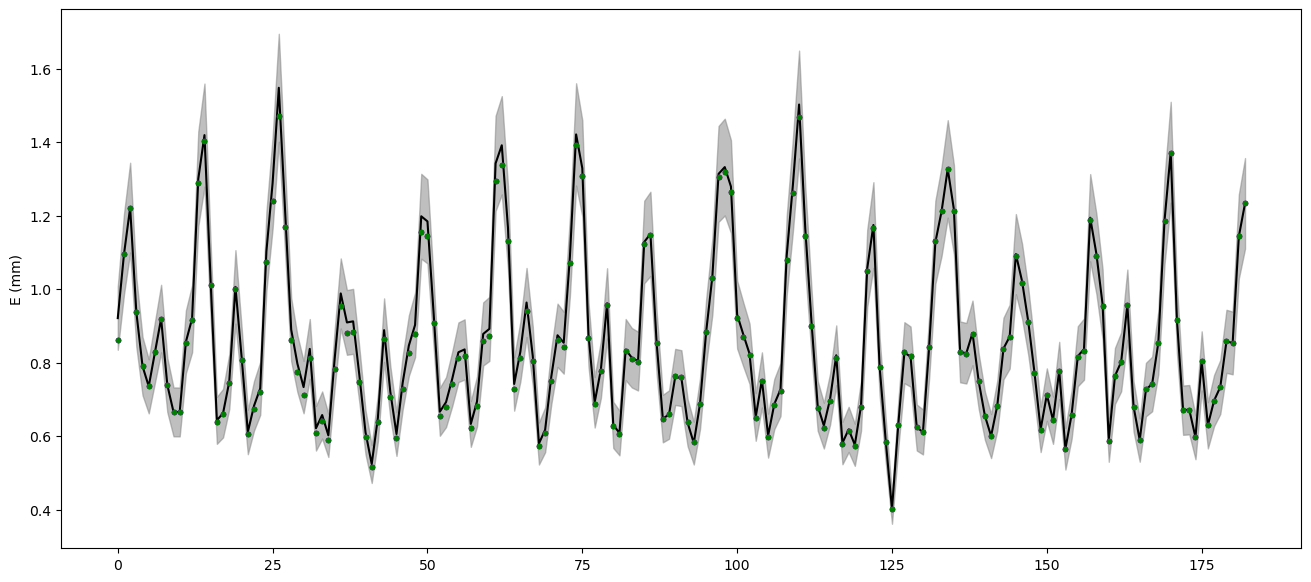

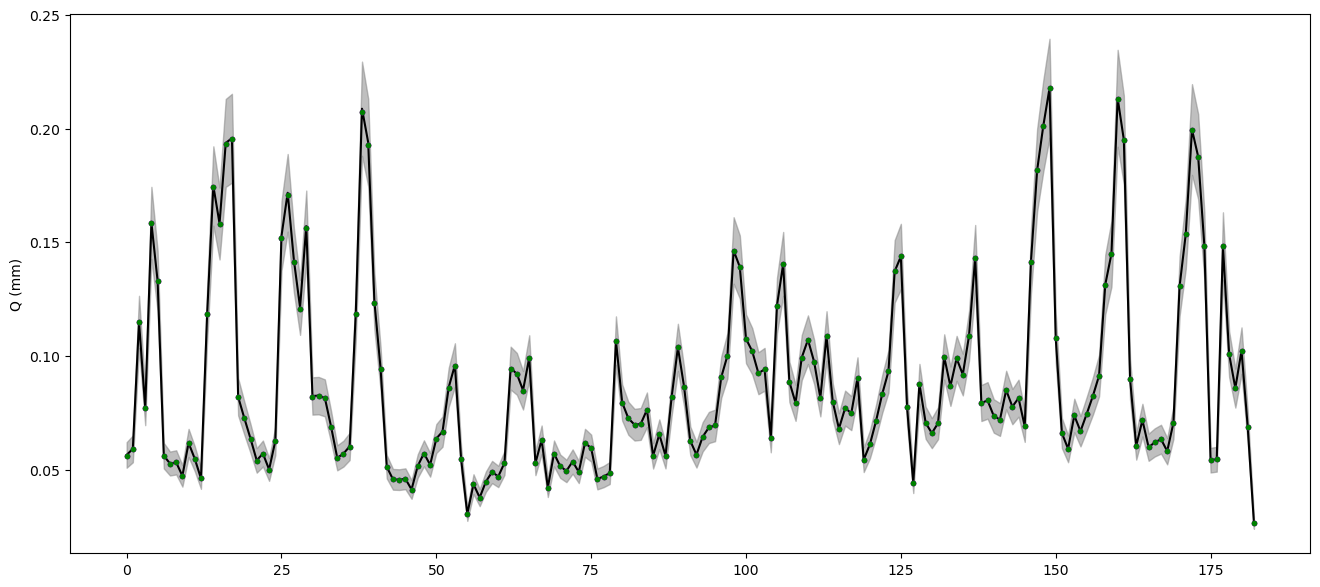

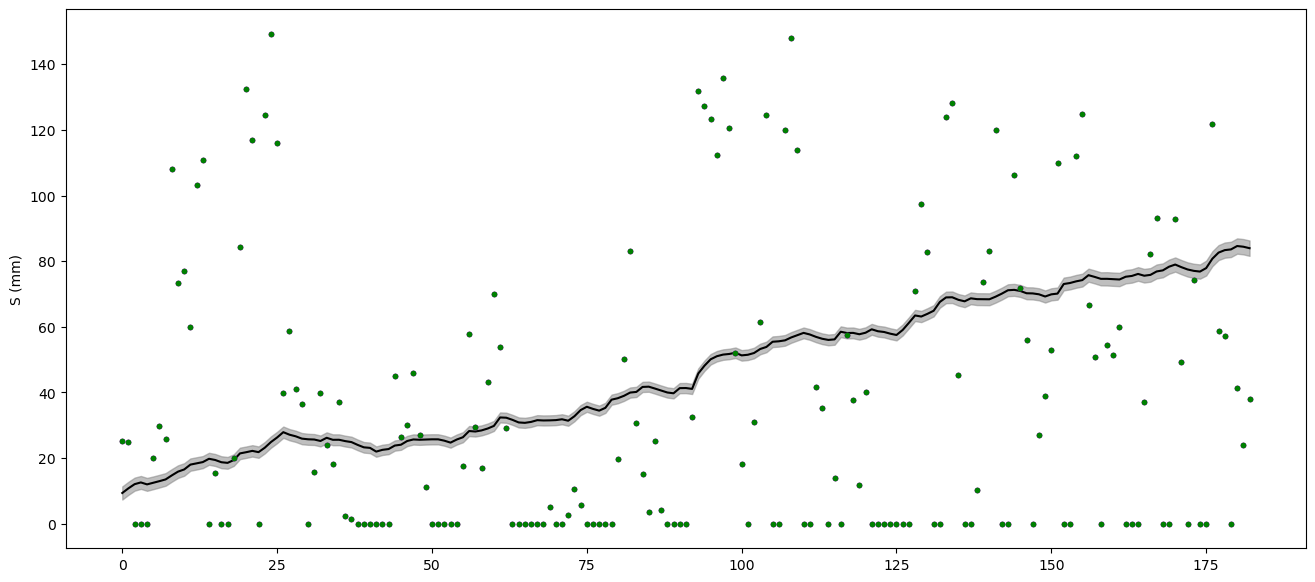

In [219]:
PlotPosterior("P (mm)", mPostP, vPostP, era5p, nasap, era5_forcing)
PlotPosterior("E (mm)", mPostE, vPostE, modis,modis,modis)
PlotPosterior("Q (mm)", mPostQ, vPostQ, Q, Q, Q)
PlotPosterior("S (mm)", mPostS, vPostS, storage, storage, storage)


### Conclusion and further extensions
This completes the notebook!

The final estimated posteriors (and results of data assimilation in general) depend to a great extent on the assumptions that are made about uncertainty in the model and the data (see e.g. assumptions we made in part 1). This is still very much an open research problem. 

For example, a [recent paper](https://doi.org/10.1029/2020WR029071) proposed specific data error models for closing the water balance. The approach used in that paper follows a similar methodology as we used in this notebook, but with additional features:
* Adding non-negativity constraints on the water balance variables to prevent non-physical negative estimates. For this a more sophisticated version of Kalman smoothing is used that involves multiple forward-backward passes over the data (iterative smoothing).
* Using data error models that contain basin-specific parameters, so that each river basin can have its own specific set of data error models. These parameters are then also estimated from the data, together with all water balance variables. 

The complete tool developed in that paper is available at https://github.com/gschoups/BasinWaterBalance. 
